In [11]:
# Before running these commands, create a virtual environment (outside project directory) using python -m venv "dir_name/env_name"
%pip install deepxde
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
%pip install chart-studio
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import deepxde as dde
import numpy as np

In [14]:
geo = dde.geometry.Interval(0, 1)
time = dde.geometry.timedomain.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geo, time)

def heat(x, u):
    du_t = dde.gradients.jacobian(u, x, i = 0, j = 1)
    du_xx = dde.gradients.hessian(u, x, i = 0, j = 0)
    return du_t - 0.4*du_xx

def true_solution(X):
    x = X[:, 0:1]
    t = X[:, 1:2]
    return np.exp(-(np.pi**2 * 0.4 * t))* np.sin(np.pi * x)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: np.sin(np.pi * x[:,0:1]), lambda _, on_initial: on_initial)

In [15]:
data = dde.data.pde.TimePDE(
    geomtime,
    heat, 
    [bc, ic], 
    num_domain=2560,
    num_boundary=80,
    num_initial=160,
    num_test=2560
)

In [16]:
net = dde.maps.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=5000)

Compiling model...
Building feed-forward neural network...
'build' took 0.176131 s

'compile' took 0.871369 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.31e+00, 5.38e-01, 4.01e-01]    [1.26e+00, 5.38e-01, 4.01e-01]    []  
1000      [6.78e-03, 8.88e-03, 1.51e-02]    [3.89e-03, 8.88e-03, 1.51e-02]    []  
2000      [1.20e-03, 2.45e-04, 4.60e-04]    [6.18e-04, 2.45e-04, 4.60e-04]    []  
3000      [3.18e-04, 6.78e-05, 8.02e-05]    [1.77e-04, 6.78e-05, 8.02e-05]    []  
4000      [1.75e-04, 3.69e-05, 3.25e-05]    [1.03e-04, 3.69e-05, 3.25e-05]    []  
5000      [1.65e-04, 7.84e-05, 1.63e-04]    [1.19e-04, 7.84e-05, 1.63e-04]    []  

Best model at step 4000:
  train loss: 2.45e-04
  test loss: 1.72e-04
  test metric: []

'train' took 31.929237 s



In [17]:
model.compile("L-BFGS-B")
losshistory, train_state=model.train()

Compiling model...
'compile' took 0.315345 s

Training model...

Step      Train loss                        Test loss                         Test metric
5000      [1.65e-04, 7.84e-05, 1.63e-04]    [1.19e-04, 7.84e-05, 1.63e-04]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  Objective function value: 0.000407
  Number of iterations: 1
  Number of functions evaluations: 37
5016      [1.65e-04, 7.84e-05, 1.63e-04]    [1.19e-04, 7.84e-05, 1.63e-04]    []  

Best model at step 4000:
  train loss: 2.45e-04
  test loss: 1.72e-04
  test metric: []

'train' took 0.851908 s



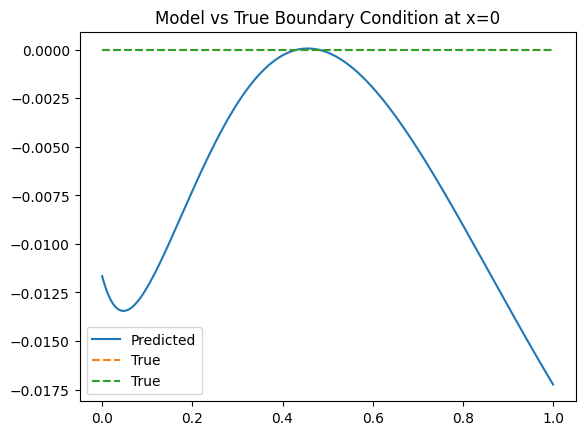

In [18]:
import matplotlib.pyplot as plt

t = np.linspace(0, 1, 200).reshape(-1, 1)
x = np.zeros_like(t)
X = np.hstack((x, t))

u_pred = model.predict(X)
u_true = 0*X

plt.plot(t, u_pred, label="Predicted")
plt.plot(t, u_true, "--", label="True")
plt.legend()
plt.title("Model vs True Boundary Condition at x=0")
plt.show()

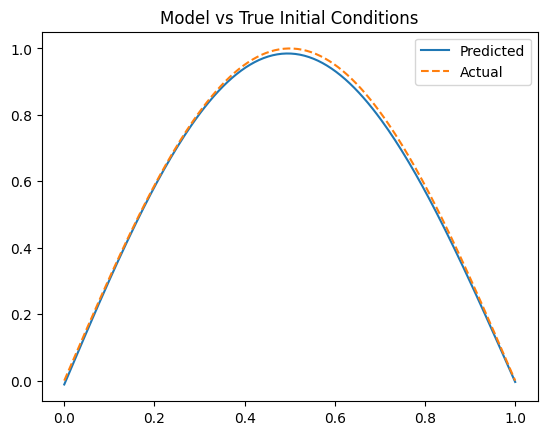

In [19]:
x = np.linspace(0, 1, 200).reshape(-1, 1)
t = np.zeros_like(x)
X = np.hstack((x, t))

u_pred = model.predict(X)
u_true = np.sin(np.pi*x)

plt.plot(x, u_pred, label="Predicted")
plt.plot(x, u_true, "--", label="Actual")
plt.legend()
plt.title("Model vs True Initial Conditions")
plt.show()

In [ ]:
import plotly.graph_objects as go

X = geomtime.random_points(1000)
y_pred = model.predict(X)
y_true = true_solution(X)

x = X[:, 0]
t = X[:, 1]

fig1=go.Figure(data=[go.Scatter3d(
    x=x, y=t, z=y_pred.flatten(), 
    mode='markers',
    marker=dict(size=2, color=y_pred.flatten(), colorscale='Viridis')
)])

fig1.update_layout(
    scene=dict(
        xaxis_title='x',
        yaxis_title='t',
        zaxis_title='u(x, t)'
    ),
    title="Interactive 3D Plot of Predicted Heat"
)

fig2=go.Figure(data=[go.Scatter3d(
    x=x, y=t, z=y_true.flatten(), 
    mode='markers',
    marker=dict(size=2, color=y_true.flatten(), colorscale='Viridis')
)])

fig2.update_layout(
    scene=dict(
        xaxis_title='x',
        yaxis_title='t',
        zaxis_title='u(x, t)'
    ),
    title="Interactive 3D Plot of Actual Heat"
)

fig1.show()
fig2.show()

